In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
print(plt.get_backend())

nbAgg


loading abae model: "./data/restaurant.train.txt.prep.abae.pt"
n_vocab: 8311 | d_embed: 200 | n_aspects: 15


<IPython.core.display.Javascript object>


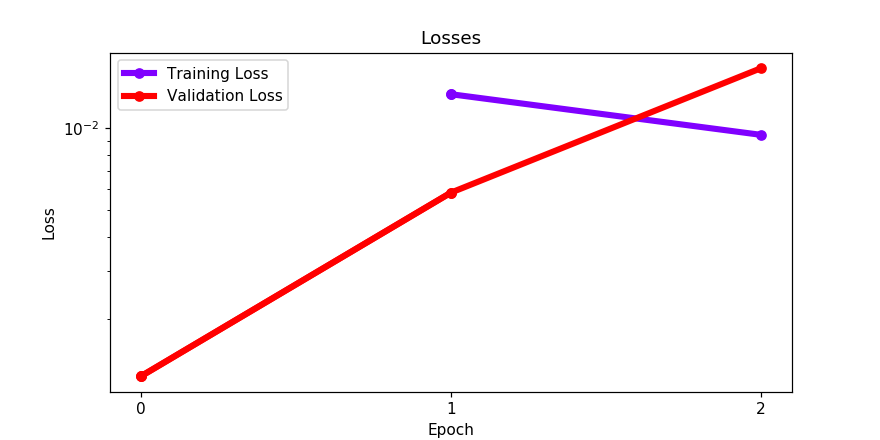

VAL BATCH: 100 | MEAN-VAL-LOSS: 0.00124: 100%|██████████| 100/100 [00:09<00:00, 11.57it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Aspect  0: mural, colorful, antique, wood, mirror, photo, wall, art
Aspect  1: placed, removed, brought, finally, finished, another, cleared, delivered
Aspect  2: hill, queen, height, eatery, avenue, st, ave, brooklyn
Aspect  3: somewhere, whenever, whether, whatever, dont, unless, want, please
Aspect  4: grit, mash, chili, mustard, loaf, mole, tangy, smothered
Aspect  5: pudding, banana, strawberry, gelato, brownie, chocolate, cooky, cheesecake
Aspect  6: convivium, beppe, perrone, mercadito, lupa, identity, zarela, rio
Aspect  7: hype, unfortunately, poor, mediocre, agree, average, expected, negative
Aspect  8: host, helpful, staff, polite, manner, sommelier, server, waitstaff
Aspect  9: yell, apologize, approached, yelled, explained, overheard, speak, spoke
Aspect 10: sister, husband, celebrated, girlfriend, boyfriend, celebrate, wife, anniversary
Aspect 11: vegetable, sauce, tuna, duck, risotto, tender, salmon, cod
Aspect 12: interesting, gourmet, unique, traditional, innovative, i

TRAIN EPOCH: 1 | LR: 0.00005 | MEAN-TRAIN-LOSS: 0.00183: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 0.00581: 100%|██████████| 100/100 [00:09<00:00, 10.68it/s]
TRAIN EPOCH: 2 | LR: 0.00005 | MEAN-TRAIN-LOSS: 0.00216:   1%|          | 1/100 [00:00<00:09,  9.96it/s]

Aspect  0: mural, colorful, antique, wood, mirror, photo, wall, art
Aspect  1: placed, removed, brought, finally, finished, another, cleared, delivered
Aspect  2: hill, queen, height, eatery, avenue, st, ave, brooklyn
Aspect  3: somewhere, whenever, whether, whatever, dont, unless, want, please
Aspect  4: grit, mash, chili, mustard, loaf, mole, tangy, smothered
Aspect  5: pudding, banana, strawberry, gelato, brownie, chocolate, cooky, cheesecake
Aspect  6: convivium, beppe, perrone, mercadito, lupa, identity, zarela, rio
Aspect  7: hype, unfortunately, poor, mediocre, agree, average, expected, negative
Aspect  8: host, helpful, staff, polite, manner, sommelier, server, waitstaff
Aspect  9: yell, apologize, approached, yelled, explained, overheard, speak, spoke
Aspect 10: sister, husband, celebrated, girlfriend, boyfriend, celebrate, wife, anniversary
Aspect 11: vegetable, sauce, tuna, duck, risotto, tender, salmon, cod
Aspect 12: interesting, gourmet, unique, traditional, innovative, i

TRAIN EPOCH: 2 | LR: 0.00000 | MEAN-TRAIN-LOSS: 0.00010: 100%|██████████| 100/100 [00:11<00:00,  7.50it/s]
VAL BATCH: 100 | MEAN-VAL-LOSS: 0.01657: 100%|██████████| 100/100 [00:09<00:00, 11.50it/s]


Aspect  0: mural, colorful, antique, wood, mirror, photo, wall, art
Aspect  1: placed, removed, brought, finally, finished, another, cleared, delivered
Aspect  2: hill, queen, height, eatery, avenue, st, ave, brooklyn
Aspect  3: somewhere, whenever, whether, whatever, dont, unless, want, please
Aspect  4: grit, mash, chili, mustard, loaf, mole, tangy, smothered
Aspect  5: pudding, banana, strawberry, gelato, brownie, chocolate, cooky, cheesecake
Aspect  6: convivium, beppe, perrone, mercadito, lupa, identity, zarela, rio
Aspect  7: hype, unfortunately, poor, mediocre, agree, average, expected, negative
Aspect  8: host, helpful, staff, polite, manner, sommelier, server, waitstaff
Aspect  9: yell, apologize, approached, yelled, explained, overheard, speak, spoke
Aspect 10: sister, husband, celebrated, girlfriend, boyfriend, celebrate, wife, anniversary
Aspect 11: vegetable, sauce, tuna, duck, risotto, tender, salmon, cod
Aspect 12: interesting, gourmet, traditional, unique, innovative, i

In [45]:
import os
import time
from abae_pytorch.data import dataloader, preprocess
from abae_pytorch.train import train
from abae_pytorch import aspect_model


#data = './data/wiki_01'
#data = './data/beer.train.txt'
data = './data/restaurant.train.txt'
prep = data + '.prep'
if not os.path.isfile(prep):
    preprocess(data, prep)


min_count = 10
d_embed = 200
n_aspects = 15
w2v = prep + '.w2v'

abae_path = prep + '.abae.pt'
device = 'cpu'

aspector = aspect_model(prep, w2v, min_count, d_embed, n_aspects, device)
if os.path.isfile(abae_path):
    aspector.load_abae(abae_path)


x = (aspector.w2v.n_vocab, aspector.w2v.d_embed, aspector.w2v.n_aspects)
print('n_vocab: %d | d_embed: %d | n_aspects: %d' % x)


split = {'train': 0.9, 'val': 0.05, 'test': 0.05}
with dataloader(aspector.w2v.w2i, prep, split=split) as dl:

    epochs = 2
    epochsize = 100
    batchsize = 100
    negsize = 20
    initial_lr = 0.0001

    if epochs > 0:
        train(aspector.ab, dl, 
              device=device,
              epochs=epochs, 
              epochsize=epochsize,
              batchsize=batchsize,
              negsize=negsize,
              initial_lr=initial_lr)

        aspector.save_abae(abae_path)

In [51]:
#x = 'like roll tiny order anyway often get order wrong stray menu'
#x = 'staff staff rube strawberry banana syrup'
#x = 'the strawberries were delicious'
#x = 'the strawberry banana pudding'
x = 'superb amazing delicious'
#x = 'staff manager waiter'
#x = "What don't I like? The rolls are tiny so you have to order more anyway and they will often get your order wrong if you stray from the menu"
#x = "Go here if you want a little bit of Korean combined with a little bit of Japanese food"
#x = "Place is casual, not fancy"
aspector.predict(x, x)

ppp tensor([[0.0706, 0.0448, 0.0721, 0.0543, 0.0642, 0.0897, 0.0438, 0.0620, 0.0771,
         0.0424, 0.0648, 0.0961, 0.0937, 0.0498, 0.0744],
        [0.0706, 0.0448, 0.0721, 0.0543, 0.0642, 0.0897, 0.0438, 0.0620, 0.0771,
         0.0424, 0.0648, 0.0961, 0.0937, 0.0498, 0.0744]],
       grad_fn=<SoftmaxBackward>)
iii tensor([[ 9,  6,  1, 13,  3,  7,  4, 10,  0,  2, 14,  8,  5, 12, 11],
        [ 9,  6,  1, 13,  3,  7,  4, 10,  0,  2, 14,  8,  5, 12, 11]])


tensor([11, 11])

In [42]:
!head -n 10 ./data/restaurant.train.txt

What do I like about Jeollado? I like the 2 for 1 rolls (sometimes 3 for 1) the prices and the variety on the menu
What don't I like? The rolls are tiny so you have to order more anyway and they will often get your order wrong if you stray from the menu
For the money, it's a dependable and fun place to get sushi - bring friends and share the 2 for 1 rolls (they have to be 2 of the same
)
This place is a great deal for the price and the food they give you
Crab rolls are made with real crab, not the imitation crab
They also have a great unagi bim bim bap that you must order
Go here if you want a little bit of Korean combined with a little bit of Japanese food
Place is casual, not fancy
Short of cash, with a big group, starving? This is the place


#
    preprocessing script for some known datasets
        num tag for preprocessing
    
    
    model wrap class

        given preprocessed data path
            train w2v models
                word embeddings trained on partitions too...
                optionally use different w2v training corpus
            initialize aspect matrix
                inferring n_aspects?
                    downweight specificity?

        given preprocessed data path, train abae model
        
        given sentences, provide aspect predictions

        save and load combinations of components


    break into package
        cli
        documentation
        setup.py
        requirements.txt